# 1. Librerias

In [1]:
import os
import random
import shutil

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16


# 2. Carga de datos

Se importaran los datos desde google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directorio para descomprimir
source_dir = "/content/drive/MyDrive/Semi-Senior Machine Learning Engineer Challenge"

In [4]:
# Crear el directorio de destino si no existe
os.makedirs(source_dir, exist_ok=True)

In [5]:
# Directorio de origen
images_dir = "/content/drive/MyDrive/Semi-Senior Machine Learning Engineer Challenge/dogs"

Se crea la funcion plot_images_with_labels para una visualización inicial.

In [6]:
def plot_images_with_labels(data_dir):
    classes = os.listdir(data_dir)

    plt.figure(figsize=(12, 12))
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        random.shuffle(images)

        for i in range(3):  # Plotear solo 3 imágenes de cada clase
            img_name = images[i]
            img_path = os.path.join(class_dir, img_name)
            img = mpimg.imread(img_path)

            plt.subplot(len(classes), 3, classes.index(class_name) * 3 + i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

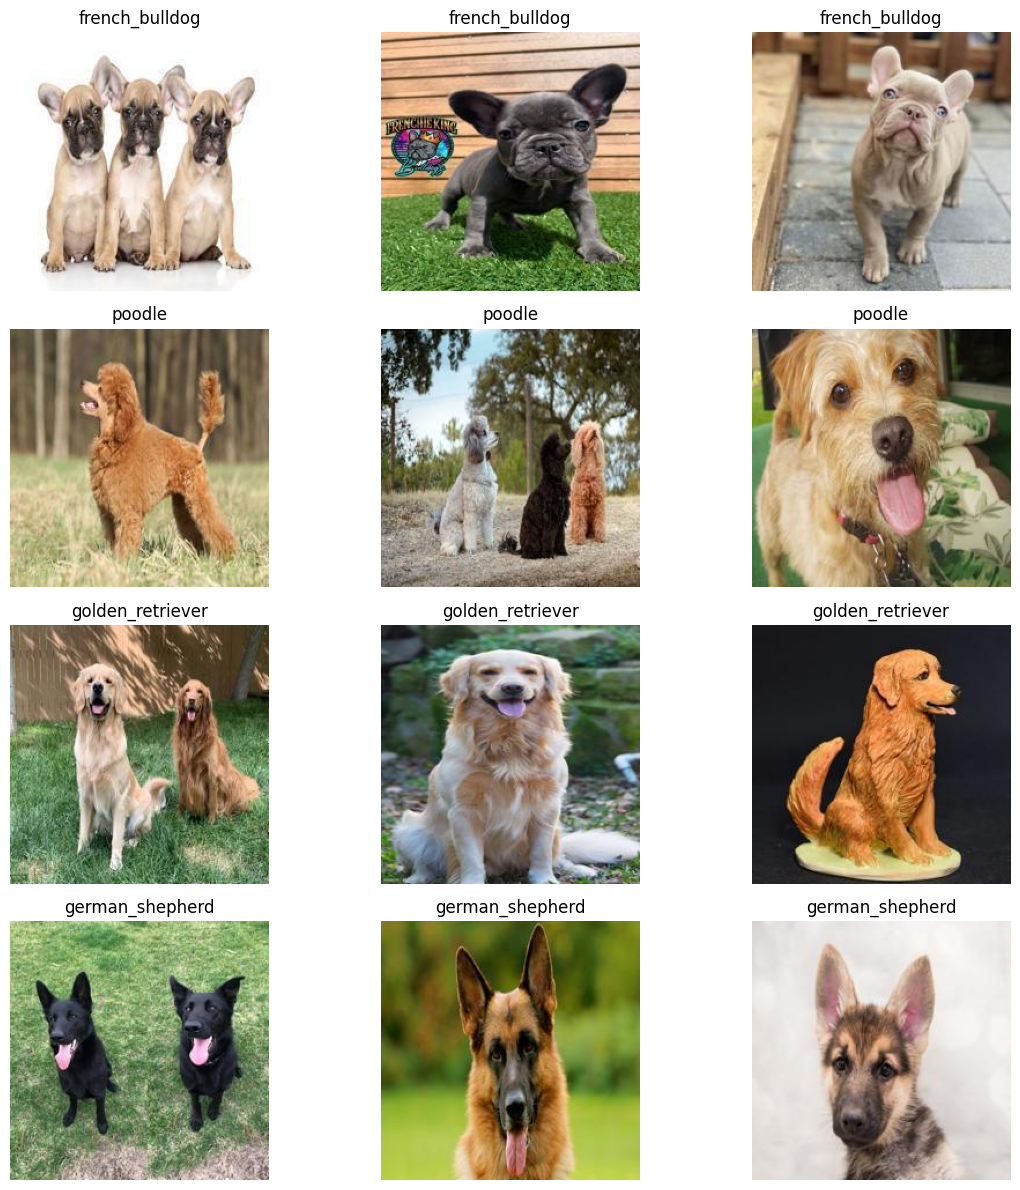

In [7]:
plot_images_with_labels(images_dir)

Debido a que la cantidad de imagenes disponibles para entrenar el modelo es pequeña (80), se utilizara como parte del modelo una red pre-entrenada. Se utilizaran resnet y VGG16, las cuales tienen un tamaño de entrada especifico para las imagenes que es 224x224 pixeles. Por este motivo, se redimensionan todas las imagenes disponibles en primera instancia.

In [8]:
# Se redimensionan las imagenes para resnet
target_width = 224
target_height = 224

In [9]:
# Recorre todas las imágenes en el directorio y las redimensiona
for root, dirs, files in os.walk(source_dir):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            img_path = os.path.join(root, filename)
            img = Image.open(img_path)

            # Redimensiona la imagen
            img_resized = img.resize((target_width, target_height))

            # Guarda la imagen redimensionada en la misma direccion
            img_resized.save(img_path)

# 3. Separacion en train y validation

In [10]:
# Directorios de destino para los conjuntos de datos
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/validation"

In [11]:
# Crear los directorios de destino si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [12]:
# Porcentaje de imagenes para entrenamiento y validation
train_ratio = 0.8
validation_ratio = 0.2

In [13]:
# Listar las clases (nombres de las subcarpetas en el directorio fuente)
classes = os.listdir(images_dir)
print(classes)

['french_bulldog', 'poodle', 'golden_retriever', 'german_shepherd']


In [14]:
# Crear subcarpetas en los directorios de entrenamiento, prueba y validación para cada clase
for class_name in classes:
    class_train_dir = os.path.join(train_dir, class_name)
    os.makedirs(class_train_dir, exist_ok=True)

    class_validation_dir = os.path.join(validation_dir, class_name)
    os.makedirs(class_validation_dir, exist_ok=True)

In [15]:
# Recorrer cada clase y mover las imágenes a los directorios correspondientes
for class_name in classes:
    class_dir = os.path.join(images_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    num_images = len(images)
    num_train = int(num_images * train_ratio)
    num_validation = int(num_images * validation_ratio)

    train_images = images[:num_train]
    validation_images = images[num_train:num_train + num_validation]

    for img_name in train_images:
        src_path = os.path.join(class_dir, img_name)
        if os.path.isfile(src_path):  # Verificar si es un archivo
            dst_path = os.path.join(train_dir, class_name, img_name)
            shutil.copy(src_path, dst_path)

    for img_name in validation_images:
        src_path = os.path.join(class_dir, img_name)
        if os.path.isfile(src_path):  # Verificar si es un archivo
            dst_path = os.path.join(validation_dir, class_name, img_name)
            shutil.copy(src_path, dst_path)

Debido a que se tienen pocas imagenes para el entrenamiento, se trabajara con Data Augmentation desde el comienzo, forzando la diversidad de datos disponibles de forma de llevar al modelo a aprender a reconocer las mismas caracteristicas, en diferentes contextos y variaciones.

In [91]:
# Crear generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Crear generador de datos para el conjunto de validación
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [92]:
# Generar datos de entrenamiento desde el directorio
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 63 images belonging to 4 classes.


Hasta acá train_generator tiene 63 imagenes pertenecientes a 4 clases pero es importante asegurar que en el split, no hayan quedado desbalanceadas.

In [19]:
# Obtener el diccionario de índices de clases
class_indices = train_generator.class_indices

# Crear un diccionario para contar las imágenes de cada clase
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Contar las imágenes de cada clase en el generador de entrenamiento
for batch, labels in train_generator:
    for label in labels:
        class_name = [k for k, v in class_indices.items() if v == label.argmax()][0]
        class_counts[class_name] += 1

    if train_generator.batch_index == 0:  # Se detiene al recorrer todo el conjunto
        break

# Imprimir el recuento de imágenes de cada clase
print("Recuento de imágenes por clase:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Recuento de imágenes por clase:
french_bulldog: 16
german_shepherd: 15
golden_retriever: 16
poodle: 16


Puede verse cuantas imagenes por clase tiene train_generator y se concluye que no se encuentra desbalanceado.

Se generara un lote de imagenes aumentadas para tener una muestra y corroborar que estan teniendo variaciones pero no perdiendo el concepto de la imagen.

In [20]:
# Generar un lote de imagenes aumentadas
augmented_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
).next()[0]

Found 63 images belonging to 4 classes.


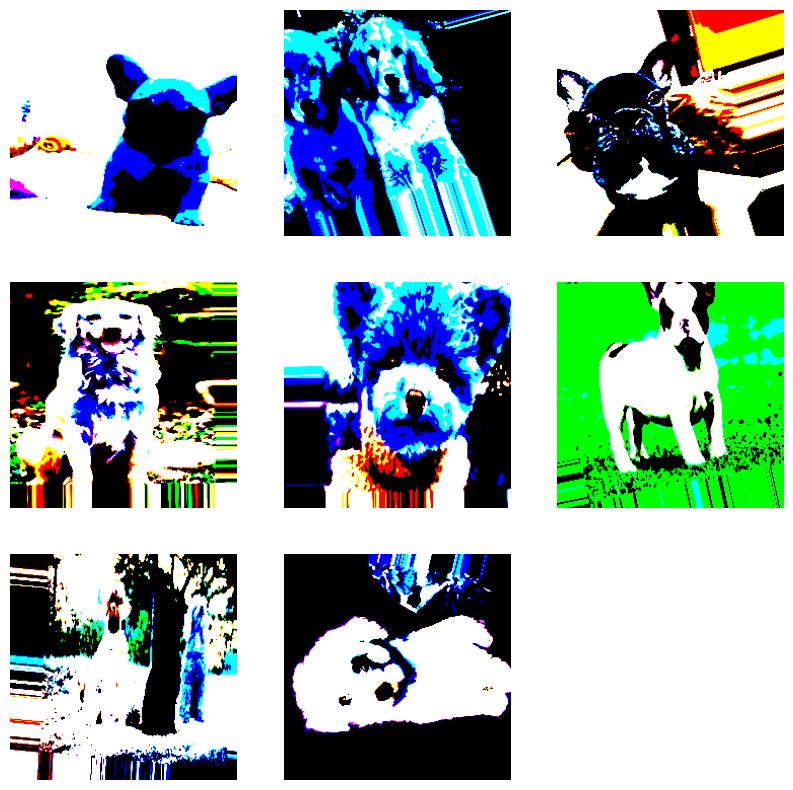

In [21]:
# Mostrar una cuadricula de imagenes aumentadas
plt.figure(figsize=(10, 10))
for i in range(augmented_images.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

Si bien se notan claramente las alteraciones, siguen viendose como perros.

In [22]:
# Generar datos de validacion desde el directorio
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 16 images belonging to 4 classes.


Como el dataset inicial estaba balanceado (20 imagenes por clase) y también train_generator, validation_generator estara también balanceado.

#4. Modelos

Como se adelanto anteriormente, se considera que se tienen muy pocos datos como para entrenar una red desde cero. Por este motivo, se generaran modelos con redes pre-entradas como base.

### **Modelo 1 - Con ResNet50**

Se trabajara con ResNet 50 con los pesos generados a partir de entrenarse con ImageNet, un dataset que contiene entre otros, imagenes de perros. Con esto se espera que el modelo represente correctamente cada una de las clases en el embedding space.

In [23]:
# Cargar la arquitectura ResNet50 preentrenada con los pesos entrenados en el conjunto de datos ImageNet sin incluir las capas densas (fully connected) superiores
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


Se agregara una capa densa al modelo base, de forma de ajustar el modelo al problema.

In [24]:
# Agregar capas adicionales al modelo base
num_classes = 4
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [25]:
# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
#Learning rate
lr = 0.001

In [27]:
# Compilar el modelo
model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
batch_size = 256
epochs = 50

In [29]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs)

Epoch 1/50
7/7 [==============================] - 13s 178ms/step - loss: 1.0722 - accuracy: 0.6364
Epoch 2/50
7/7 [==============================] - 1s 96ms/step - loss: 0.1530 - accuracy: 0.9091
Epoch 3/50
7/7 [==============================] - 1s 104ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 1s 106ms/step - loss: 0.0296 - accuracy: 0.9818
Epoch 5/50
7/7 [==============================] - 1s 106ms/step - loss: 0.0122 - accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 1s 102ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 1s 101ms/step - loss: 0.0093 - accuracy: 1.0000
Epoch 8/50
7/7 [==============================] - 1s 107ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 9/50
7/7 [==============================] - 1s 107ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 10/50
7/7 [==============================] - 1s 121ms/step - loss: 8.8816e-05 - accuracy: 1.0000
Epoch 11/50
7/7

In [30]:
# Evaluar el modelo en los datos de validacion
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

2/2 [==============================] - 1s 59ms/step - loss: 0.0450 - accuracy: 1.0000
Validation Loss: 0.044979847967624664
Validation Accuracy: 1.0


Con el primer modelo se alcanza un 100% de Accuracy en train y 100% de Accuracy en Validation.

### **Modelo 2 - Con VGG16**

Se probara un segundo modelo, de forma análoga al primero, utilizando los pesos de haberse entrenado VGG16 con imagenet.

In [59]:
# Cargar la arquitectura VGG16 preentrenada con los pesos entrenados en el conjunto de datos ImageNet sin incluir las capas densas superiores
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model2.trainable = False

In [60]:
# Agregar capas adicionales al modelo base
num_classes = 4
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions2 = Dense(num_classes, activation='softmax')(x)

In [61]:
# Crear el modelo final
model2 = Model(inputs=base_model2.input, outputs=predictions2)

In [62]:
# Compilar el modelo
model2.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
lr = 0.001
batch_size = 256
epochs = 50

In [64]:
# Entrenar el modelo con datos de validacion
history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs)

Epoch 1/50
6/6 [==============================] - 4s 173ms/step - loss: 4.6252 - accuracy: 0.3500
Epoch 2/50
6/6 [==============================] - 2s 268ms/step - loss: 1.5133 - accuracy: 0.6792
Epoch 3/50
6/6 [==============================] - 1s 126ms/step - loss: 1.0679 - accuracy: 0.8113
Epoch 4/50
6/6 [==============================] - 1s 109ms/step - loss: 0.7407 - accuracy: 0.8491
Epoch 5/50
6/6 [==============================] - 1s 108ms/step - loss: 0.0687 - accuracy: 0.9623
Epoch 6/50
6/6 [==============================] - 1s 128ms/step - loss: 0.4797 - accuracy: 0.9245
Epoch 7/50
6/6 [==============================] - 1s 110ms/step - loss: 0.2337 - accuracy: 0.9434
Epoch 8/50
6/6 [==============================] - 1s 114ms/step - loss: 0.0879 - accuracy: 0.9623
Epoch 9/50
6/6 [==============================] - 1s 123ms/step - loss: 0.0265 - accuracy: 0.9811
Epoch 10/50
6/6 [==============================] - 1s 179ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 11/50
6/6 [==

In [66]:
# Evaluar el modelo en los datos de validacion
validation_loss, validation_accuracy = model2.evaluate(validation_generator)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

2/2 [==============================] - 0s 82ms/step - loss: 1.0627 - accuracy: 0.9375
Validation Loss: 1.0627062320709229
Validation Accuracy: 0.9375


Con el segundo modelo se alcanza un 100% de Accuracy en train y 93,8% de Accuracy en Validation.

El valor de Accuracy en Validation empeoró respecto al primer modelo. Por este motivo, se decide continuar trabajando con el modelo 1.

#5. Estrategias para combatir el overfitting

Aclaración: Las estrategias para combatir el overfitting se desarrollaron a lo largo de la resolución del problema, cuando aún no se habían alcanzado valores de Accuracy 100%. De todas formas, cabe destacar que, el problema posee una cantidad muy limitada de imagenes iniciales, se estima que estas técnicas podrían ser de utilidad para un caso real con un cliente.

Se trabajara con dos estrategias para atacar el overfitting:

- Se aumentarán los parametros de data augmentation en pos de generar más datos de entrenamiento y/o mayores rangos de variación
- Se aplicará a la loss la técnica de regularización L2

### Data augmentation

In [67]:
#Se cambian parametros y batch size de train_generator 8 a 10

In [68]:
# Crear generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [69]:
# Generar datos de entrenamiento desde el directorio
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

Found 63 images belonging to 4 classes.


In [70]:
# Generar un lote de imagenes aumentadas
augmented_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
).next()[0]

Found 63 images belonging to 4 classes.


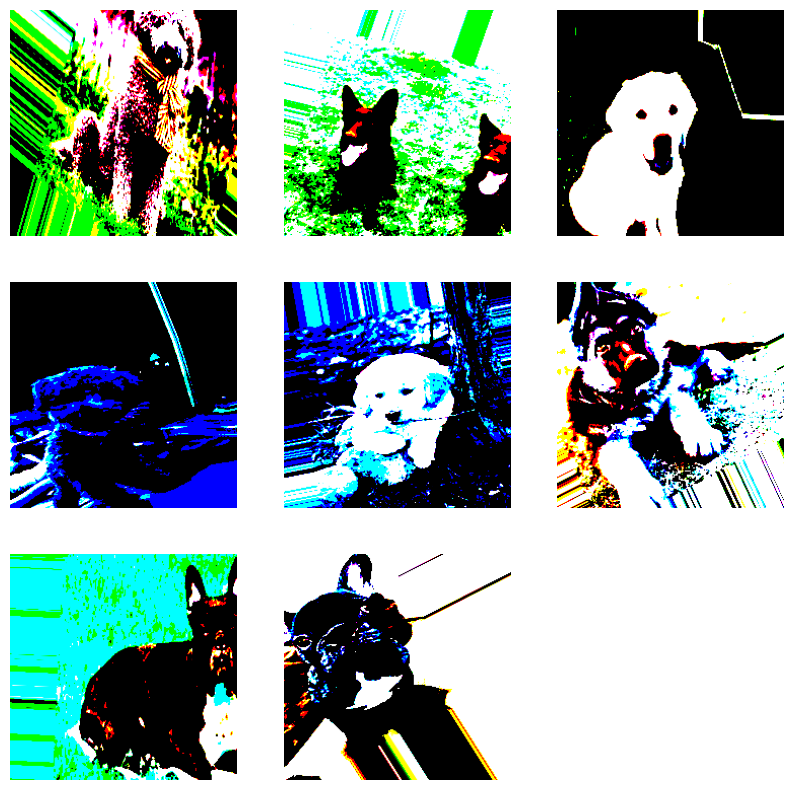

In [71]:
# Mostrar una cuadrícula de imagenes aumentadas
plt.figure(figsize=(10, 10))
for i in range(augmented_images.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

Se chequean nuevamente las imagenes.

In [73]:
lr = 0.001
batch_size = 256
epochs = 50

In [74]:
# Entrenar el modelo con datos de validacion
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs)

Epoch 1/50
6/6 [==============================] - 1s 110ms/step - loss: 5.2433e-05 - accuracy: 1.0000
Epoch 2/50
6/6 [==============================] - 1s 132ms/step - loss: 7.3166e-05 - accuracy: 1.0000
Epoch 3/50
6/6 [==============================] - 1s 111ms/step - loss: 0.0541 - accuracy: 0.9623
Epoch 4/50
6/6 [==============================] - 1s 136ms/step - loss: 6.4249e-05 - accuracy: 1.0000
Epoch 5/50
6/6 [==============================] - 1s 219ms/step - loss: 3.8801e-04 - accuracy: 1.0000
Epoch 6/50
6/6 [==============================] - 1s 192ms/step - loss: 2.8115e-07 - accuracy: 1.0000
Epoch 7/50
6/6 [==============================] - 1s 177ms/step - loss: 2.2505e-04 - accuracy: 1.0000
Epoch 8/50
6/6 [==============================] - 1s 111ms/step - loss: 0.1408 - accuracy: 0.9811
Epoch 9/50
6/6 [==============================] - 1s 111ms/step - loss: 1.4366e-04 - accuracy: 1.0000
Epoch 10/50
6/6 [==============================] - 1s 106ms/step - loss: 4.9336e-05 - accu

In [75]:
# Evaluar el modelo en los datos de validacion
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

2/2 [==============================] - 0s 46ms/step - loss: 0.2858 - accuracy: 0.9375
Validation Loss: 0.28575536608695984
Validation Accuracy: 0.9375


No se obtuvieron iguales resultados que para el modelo 1 (peores valores de Loss y Accuracy en Validation)

### Regularizacion - L2

Se agrega regularizacion a la ultima capa densa como segunda estrategia para evitar overfitting

Aclaración: se olvió a trabajar con el train_generator inicial (parametros de data augmentation iniciales)

In [93]:
# Agregar capas adicionales al modelo base
num_classes = 4
y = base_model.output
y = GlobalAveragePooling2D()(y)
y = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(y)
predictions_reg = Dense(num_classes, activation='softmax')(y)

In [94]:
# Crear el modelo final
model_reg = Model(inputs=base_model.input, outputs=predictions_reg)

In [95]:
#Learning rate
lr = 0.001

In [96]:
# Compilar el modelo
model_reg.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
batch_size = 8
epochs = 50

In [98]:
# Entrenar el modelo con datos de validación
history = model_reg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs)

Epoch 1/50
7/7 [==============================] - 4s 105ms/step - loss: 8.9694 - accuracy: 0.6545
Epoch 2/50
7/7 [==============================] - 1s 105ms/step - loss: 7.1664 - accuracy: 0.9643
Epoch 3/50
7/7 [==============================] - 1s 105ms/step - loss: 6.2692 - accuracy: 0.9818
Epoch 4/50
7/7 [==============================] - 1s 104ms/step - loss: 5.5242 - accuracy: 0.9818
Epoch 5/50
7/7 [==============================] - 1s 104ms/step - loss: 4.8786 - accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 1s 103ms/step - loss: 4.3600 - accuracy: 0.9636
Epoch 7/50
7/7 [==============================] - 1s 135ms/step - loss: 3.8670 - accuracy: 1.0000
Epoch 8/50
7/7 [==============================] - 3s 392ms/step - loss: 3.4572 - accuracy: 1.0000
Epoch 9/50
7/7 [==============================] - 1s 121ms/step - loss: 3.1047 - accuracy: 1.0000
Epoch 10/50
7/7 [==============================] - 1s 162ms/step - loss: 2.7998 - accuracy: 1.0000
Epoch 11/50
7/7 [==

In [99]:
# Evaluar el modelo en los datos de validacion
validation_loss, validation_accuracy = model_reg.evaluate(validation_generator)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

2/2 [==============================] - 1s 61ms/step - loss: 0.3328 - accuracy: 1.0000
Validation Loss: 0.3328245282173157
Validation Accuracy: 1.0


Con esta tecnica se obtienen nuevamente valores de Accuracy del 100%.

#6. Prueba en test

Para continuar evaluando la performance del modelo, se evaluará como performa en nuevas imagenes diferentes a las otorgadas por el problema (conjunto de Test)

In [83]:
# Directorio de origen para separarlas
images2_dir = "/content/drive/MyDrive/Semi-Senior Machine Learning Engineer Challenge/NEW_dogs"

In [84]:
# Recorre todas las imágenes en el directorio y las redimensiona
for root, dirs, files in os.walk(images2_dir):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            img_path = os.path.join(root, filename)
            img = Image.open(img_path)
            # Redimensiona la imagen
            img_resized = img.resize((target_width, target_height))
            # Guarda la imagen redimensionada en la misma direccion
            img_resized.save(img_path)

In [85]:
# Listar las clases (nombres de las subcarpetas en el directorio fuente)
classes = os.listdir(images2_dir)
print(classes)

['french_bulldog', 'poodle', 'golden_retriever', 'german_shepherd']


A continuación se observan las nuevas imagenes

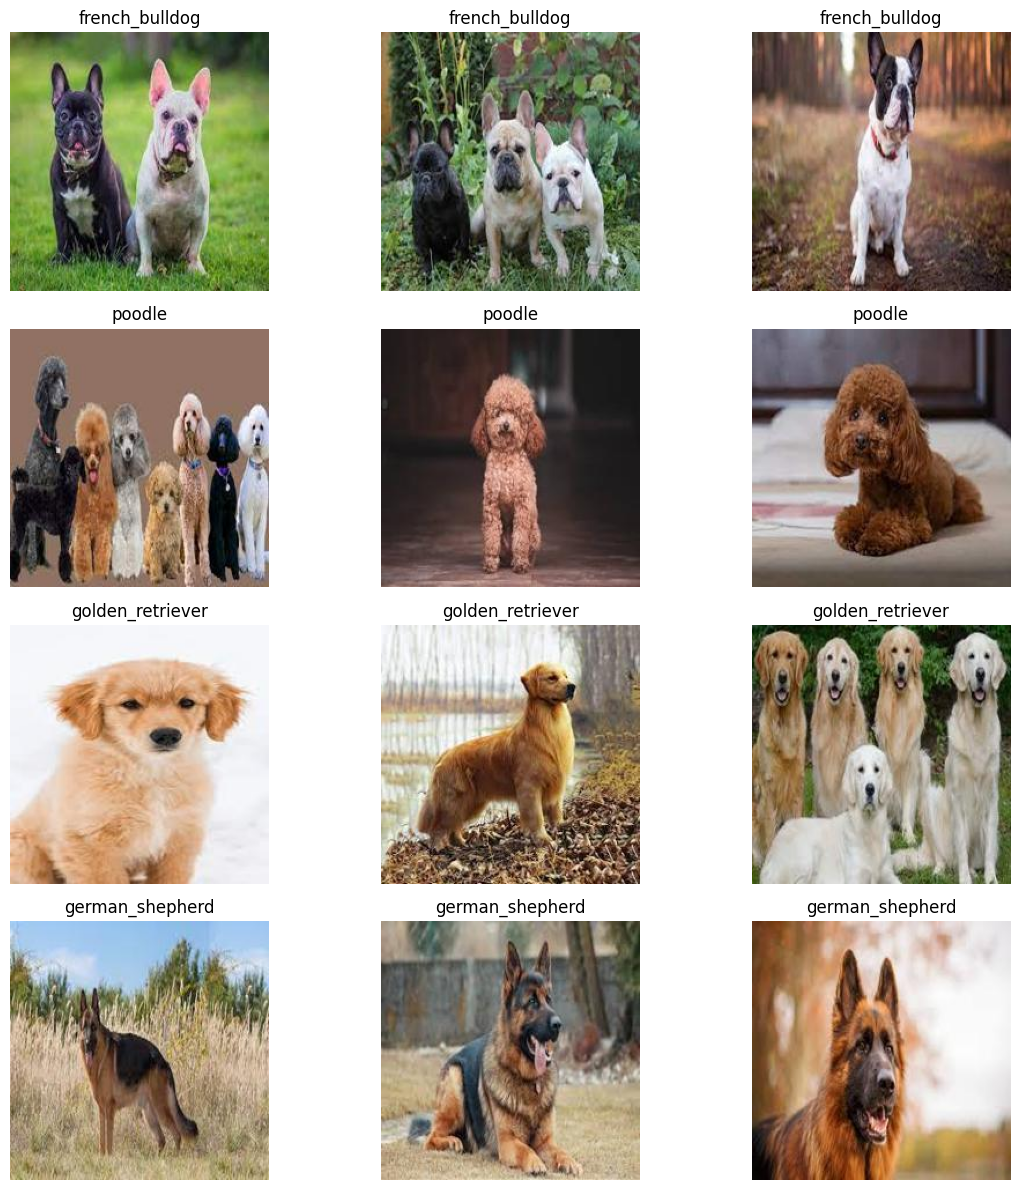

In [101]:
plot_images_with_labels(images2_dir)

In [86]:
  # Crear generador de datos para las imagenes nuevas
new_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [87]:
# Generar datos nuevos desde el directorio
new_generator = new_datagen.flow_from_directory(
    images2_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 40 images belonging to 4 classes.


In [88]:
# Evaluar el modelo que mejor performo en los datos nuevos (modelo 1)
Test_loss, Test_accuracy = model.evaluate(new_generator)
print("Test Loss:", Test_loss)
print("Test Accuracy:", Test_accuracy)

5/5 [==============================] - 0s 48ms/step - loss: 0.1488 - accuracy: 0.9750
Test Loss: 0.14881128072738647
Test Accuracy: 0.9750000238418579


En imagenes nuevas, diferentes a las otorgadas por el problema, se obtiene un Test Accuracy de 97,5%, considerandose un valor satisfactorio.

Igualmente, se decide evaluar los datos con los otros dos modelos construidos (model2 y model_reg). Con ellos se obtienen también buenos resultados de Accuracy, pero no superiores a los del modelo 1.

In [89]:
# Evaluar el modelo 2 en los datos nuevos
Test_loss, Test_accuracy = model2.evaluate(new_generator)
print("Test Loss:", Test_loss)
print("Test Accuracy:", Test_accuracy)

5/5 [==============================] - 0s 65ms/step - loss: 0.1530 - accuracy: 0.9500
Test Loss: 0.15298599004745483
Test Accuracy: 0.949999988079071


In [100]:
# Evaluar el modelo_reg en los datos nuevos
Test_loss, Test_accuracy = model_reg.evaluate(new_generator)
print("Test Loss:", Test_loss)
print("Test Accuracy:", Test_accuracy)

5/5 [==============================] - 0s 48ms/step - loss: 0.4867 - accuracy: 0.9250
Test Loss: 0.4866752028465271
Test Accuracy: 0.925000011920929


#7. Conclusiones

El mejor modelo fue el modelo 1 (model), aquel que fue desarrollado a partir de una red preentrenada ResNet50, con el agregado de una capa densa de salida. El modelo alcanzo un 97,5% de Accuracy al probarlo con imagenes nunca vistas, adicionales a la letra del problema.

Resulta importante recalcar nuevamente que durante el desarrollo de la resolución, no siempre los valores de Accuracy fueron tan elevados. Asímismo por la poca cantidad de imagenes iniciales, los modelos en primera instancia tendían a que se presuma la existencia de Overfitting (valores de accuracy en train considerablemente más altos que los valores de accuracy en validation) por eso el desarrollo posterior de las técnicas para atacarlo.

#8. Oportunidades

A continuación se listarán algunas oportunidades futuras que encuentro podrían mejorar la resolución del trabajo:

- La letra del problema indica que se probará con imagenes de "new unseen classes". Por este motivo seria bueno sumar un compilado de imagenes denominado "others" como 5ta clase adicional, en donde se tenga una mezcla de imagenes de perros de razas que no esten contenidas en las cuatro clases originales. De esta forma se intentaría abarcar esos casos de forma de que el modelo no los clasifique erróneamente.
- Como otra alternativa, se podría incluir en el codigo un umbral de probabilidad, el cual sea comparado con las probabilidades de pertenecer a cada una de las clases de cada imagen. Si la probabilidad es menor al umbral, denotará que "no es tan probable" que pertenezca a la clase con la que fue clasificada y sabremos que es probable que sea un caso de una raza de perro diferente a las cuatro originales.
- Investigar y evaluar la posibilidad de utilizar un modelo "zero-shot learning", los cuales pueden resultar útiles para casos en los que existe falta de datos de entrenamiento.